In [1]:
import gym
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime
from __future__ import print_function, division
from builtins import range

In [2]:
class HiddenLayer:
    def __init__(self, M1, M2, f=tf.nn.tanh, use_bias=True):
        self.W = tf.Variable(tf.random_normal(shape=(M1, M2)))
        self.params = [self.W]
        self.use_bias = use_bias
        if use_bias:
            self.b = tf.Variable(np.zeros(M2).astype(np.float32))
            self.params.append(self.b)
        self.f = f


    def forward(self, X):
        if self.use_bias:
            a = tf.matmul(X, self.W) + self.b
        else:
            a = tf.matmul(X, self.W)
        return self.f(a)

In [3]:
class DQN:
    def __init__(self, D, K, hidden_layer_sizes, gamma, max_experiences=10000, min_experiences=100, batch_sz=32):
        self.K = K
        self.layers = []
        M1 = D

        for M2 in hidden_layer_sizes:
            layer = HiddenLayer(M1, M2)
            self.layers.append(layer)
            M1 = M2


        layer = HiddenLayer(M1, K, lambda x: x)
        self.layers.append(layer)


        self.params = []
        for layer in self.layers:
            self.params += layer.params


        self.X = tf.placeholder(tf.float32, shape=(None, D), name='X')
        self.G = tf.placeholder(tf.float32, shape=(None,), name='G')
        self.actions = tf.placeholder(tf.int32, shape=(None,), name='actions')

        Z = self.X
        for layer in self.layers:
            Z = layer.forward(Z)

        Y_hat = Z
        self.predict_op = Y_hat

        selected_action_values = tf.reduce_sum(
        Y_hat * tf.one_hot(self.actions, K),
        reduction_indices=[1]
         )

        cost = tf.reduce_sum(tf.square(self.G - selected_action_values))
        self.train_op = tf.train.AdagradOptimizer(1e-2).minimize(cost)


        self.experience = {'s': [], 'a': [], 'r': [], 's_next': [], 'done': []}
        self.max_experiences = max_experiences
        self.min_experiences = min_experiences
        self.batch_sz = batch_sz
        self.gamma = gamma


    def set_session(self, session):
        self.session = session


    def copy_from(self, other):
        ops = []
        my_params = self.params
        other_params = other.params
        for p, q in zip(my_params, other_params):
            actual = self.session.run(q)
            op = p.assign(actual)
            ops.append(op)

        self.session.run(ops)


    def predict(self, X):
        X = np.atleast_2d(X)
        return self.session.run(self.predict_op, feed_dict={self.X: X})



    def train(self, target_network):
        if len(self.experience['s']) < self.min_experiences:
            return


        idx = np.random.choice(len(self.experience['s']), size=self.batch_sz, replace=False)
        states = [self.experience['s'][i] for i in idx]
        actions = [self.experience['a'][i] for i in idx]
        rewards = [self.experience['r'][i] for i in idx]
        next_states = [self.experience['s_next'][i] for i in idx]
        dones = [self.experience['done'][i] for i in idx]
        next_Q = np.max(target_network.predict(next_states), axis=1)
        targets = [r + self.gamma*next_q if not done else r for r, next_q, done in zip(rewards, next_Q, dones)]

        self.session.run(
            self.train_op,
            feed_dict={
                self.X: states,
                self.G: targets,
                self.actions: actions
            }
        )

    def add_experience(self, s, a, r, s_next, done):
        if len(self.experience['s']) >= self.max_experiences:
            self.experience['s'].pop(0)
            self.experience['a'].pop(0)
            self.experience['r'].pop(0)
            self.experience['s_next'].pop(0)
            self.experience['done'].pop(0)
        self.experience['s'].append(s)
        self.experience['a'].append(a)
        self.experience['r'].append(r)
        self.experience['s_next'].append(s_next)
        self.experience['done'].append(done)


    def sample_action(self, x, eps):
        if np.random.random() < eps:
            return np.random.choice(self.K)
        else:
            X = np.atleast_2d(x)
        return np.argmax(self.predict(X)[0])

In [4]:
def plot_running_avg(total_rewards):
    n = len(total_rewards)
    running_avg = np.empty(n)

    for t in range(n):
        running_avg[t] = total_rewards[max(0, t-100):(t+1)].mean()

    plt.plot(running_avg)
    plt.title("Running Average")
    plt.show()

In [5]:
def play_episode(env, model, tmodel, eps, gamma, copy_period):
    observation = env.reset()
    done = False
    total_reward = 0
    iteration = 0

    while not done:
        action = model.sample_action(observation, eps)
        prev_observation = observation
        observation, reward, done, info = env.step(action)
        total_reward += reward
        iteration += 1

        if done:
            reward = -200

        model.add_experience(prev_observation, action, reward, observation, done)
        model.train(tmodel)

        if iteration % copy_period == 0:
            tmodel.copy_from(model)
  
    return total_reward

episode: 0 total reward: 14.0 eps: 1.0
avg reward (last 100): 14.0
episode: 100 total reward: 14.0 eps: 0.099503719021
avg reward (last 100): 13.9306930693
episode: 200 total reward: 12.0 eps: 0.0705345615859
avg reward (last 100): 12.1584158416
episode: 300 total reward: 14.0 eps: 0.0576390417704
avg reward (last 100): 12.7722772277
episode: 400 total reward: 13.0 eps: 0.0499376169439
avg reward (last 100): 12.6534653465
episode: 500 total reward: 15.0 eps: 0.0446767051609
avg reward (last 100): 13.4851485149
episode: 600 total reward: 11.0 eps: 0.0407908508224
avg reward (last 100): 14.3465346535
episode: 700 total reward: 12.0 eps: 0.03776947873
avg reward (last 100): 13.8316831683
episode: 800 total reward: 12.0 eps: 0.0353332626669
avg reward (last 100): 14.2079207921
episode: 900 total reward: 13.0 eps: 0.0333148302326
avg reward (last 100): 14.396039604
episode: 1000 total reward: 15.0 eps: 0.0316069770621
avg reward (last 100): 14.3564356436
episode: 1100 total reward: 16.0 eps

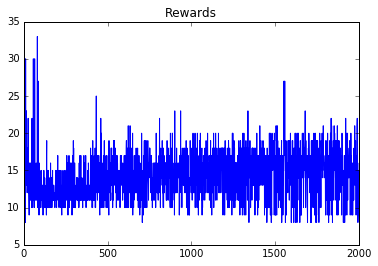

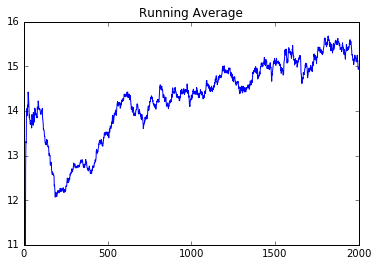

In [6]:
if __name__ == '__main__':
    env = gym.make('CartPole-v0')
    gamma = 0.99
    copy_period = 50
    
    D = len(env.observation_space.sample())
    K = env.action_space.n
    
    sizes = [200, 200]
    model = DQN(D, K, sizes, gamma)
    tmodel = DQN(D, K, sizes, gamma)
    
    init = tf.global_variables_initializer()
    session = tf.InteractiveSession()
    session.run(init)
    
    model.set_session(session)
    tmodel.set_session(session)
    
    N = 2000
    total_rewards = np.empty(N)
    costs = np.empty(N)
    
    for n in range(N):
        eps = 1.0/np.sqrt(n+1)
        total_reward = play_episode(env, model, tmodel, eps, gamma, copy_period)
        total_rewards[n] = total_reward
        
        if n % 100 == 0:
            print("episode:", n, "total reward:", total_reward, "eps:", eps)
            print("avg reward (last 100):", total_rewards[max(0, n-100):(n+1)].mean())

    print("avg reward for last 100 episodes:", total_rewards[-100:].mean())
    print("total steps:", total_rewards.sum())
    plt.plot(total_rewards)

    plt.title("Rewards")
    plt.show()

    plot_running_avg(total_rewards)